### Курсовая работа по Data Science

Импортируем библиотеки

In [36]:
import numpy as np
import pandas as pd

Пропишем путь к датасету

In [37]:
TRAIN_DATA_PATH = './real-estate-price-prediction-moscow/train.csv'

Откроем тренировочный датасет

In [38]:
df = pd.read_csv(TRAIN_DATA_PATH, sep=',')
df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


Добавим функцию обнаружения выбросов по алгоритму Z-Score

In [39]:
def zscore(column):
    outliers = []
    threshold = 3.5
    mean = column.mean()
    std = column.std()
    for cell in column:
        z_score = (cell - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(cell)
    return outliers

Добавим функцию конвертации категориальных переменных в дамми

In [40]:
def convert_to_dummies(df, col):
    if col not in df.columns:
        return df
    
    new_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    new_df.drop(col, axis=1, inplace=True)
    return new_df

Подготовим данные

In [41]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        # Медиана, а не среднее арифметическое, потому что медиана
        # не смещается из-за выбросов
        self.medians = None
        self.cols_with_missing = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Отметим столбцы с незаполненными ячейками
        
        self.cols_with_missing = [col for col in df.columns 
                                 if df[col].isnull().any()]
        
        # Раcчитаем медианные значения
        
        self.medians = [df[col].median() for col in self.cols_with_missing]
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        
        for i in range(len(self.cols_with_missing)):
            col = self.cols_with_missing[i]
            df[col + '_was_missing'] = df[col].isnull()
            df[col].fillna(self.medians[i], inplace=True)
        
        # 2. Выбросы
        
        for col in df.columns:
            if df[col].dtype != 'object':
                df.loc[df[col].isin(zscore(df[col])), col] = df[col].median()
        
        # 3. Новые признаки
        
        df = convert_to_dummies(df, "Ecology_2")
        df = convert_to_dummies(df, "Ecology_3")
        df = convert_to_dummies(df, "Shops_2")
        
        return df

In [42]:
pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)

In [43]:
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,LifeSquare_was_missing,Healthcare_1_was_missing,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,11809.0,27.0,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,0.0,305018.871089,True,True,0,1,0,1,0,1
1,3013.0,22.0,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0.0,177734.553407,False,False,0,1,0,1,0,1
2,8215.0,1.0,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,1.0,282078.720850,False,False,0,1,0,1,0,1
3,2352.0,1.0,1.0,40.409907,32.781260,1.0,10.0,22.0,1977.0,0.007122,...,1.0,168106.007630,True,True,0,1,0,1,0,1
4,13866.0,94.0,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,6.0,343995.102962,False,True,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260.0,61.0,2.0,49.090728,33.272626,6.0,3.0,12.0,1981.0,0.300323,...,9.0,119367.455796,False,True,0,1,0,1,0,1
9996,16265.0,27.0,2.0,64.307684,37.038420,9.0,13.0,0.0,1977.0,0.072158,...,0.0,199715.148807,False,True,0,1,0,1,1,0
9997,2795.0,178.0,1.0,29.648057,16.555363,5.0,3.0,5.0,1958.0,0.460556,...,5.0,165953.912580,False,True,0,1,0,1,0,1
9998,14561.0,21.0,1.0,32.330292,22.326870,5.0,3.0,9.0,1969.0,0.194489,...,5.0,171842.411855,False,False,0,1,0,1,0,1


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

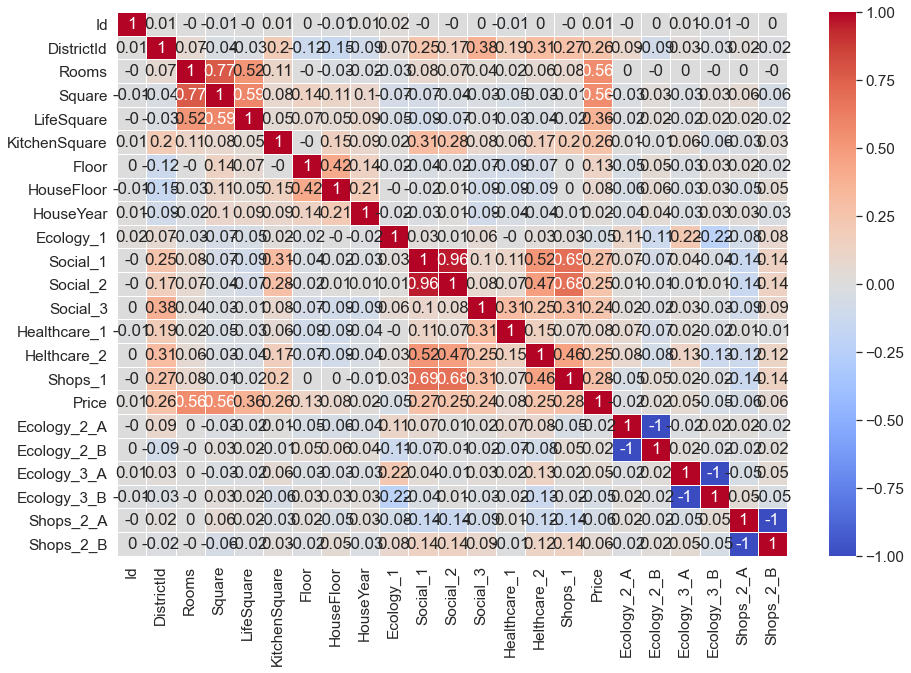

In [53]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = np.round(df.corr(), 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')